### Import Libraries

In [1]:
import os
import datasets

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 2. (필수) 나머지 라이브러리를 임포트합니다.
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_model, LoraConfig
from transformers import BitsAndBytesConfig

c:\Users\user\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 1. 데이터 로드 ---
path = "../dataset/"
try:
    raw_dataset = load_dataset("csv", data_files=path + "train.csv")
    print("Dataset loaded.")
except Exception as e:
    print(f"데이터셋 로드 실패: {e}")
    print("경로를 확인하세요.")
    raise e  # 오류 발생 시 실행 중단

# --- 2. 토크나이저 로드 (Windows 교착 상태 방지) ---
model_name = "microsoft/deberta-v3-small"
print("Loading tokenizer...")
try:
    # use_fast=False가 Windows 충돌을 방지하는 데 가장 확실합니다.
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
except Exception as e:
    print(f"Tokenizer 로드 실패: {e}")
    print("인터넷 연결을 확인하거나 로컬 경로를 사용하세요.")
    raise e  # 오류 발생 시 실행 중단
print("Tokenizer loaded.")

Dataset loaded.
Loading tokenizer...
Tokenizer loaded.


In [4]:
# --- 5. 데이터셋 분할 ---
# (회귀(float) 작업이므로 stratify_by_column 옵션 제거)
final_datasets = tokenized_dataset["train"].train_test_split(test_size=0.2, seed=42)

train_dataset = final_datasets["train"]
val_dataset = final_datasets["test"]
print(f"New train dataset size: {len(train_dataset)}")  # 샘플 수가 약 2배로 늘어남

New train dataset size: 45981


In [7]:
# --- 3. [핵심 변경] "전략적 잘림" 전처리 함수 (개선판) ---

# 전처리 함수에서 사용할 토큰 "예산"을 미리 정의합니다.
MAX_LEN = 512
PROMPT_BUDGET = 150  # 프롬프트에 할당할 최대 토큰 수
RESPONSE_BUDGET = 170  # 각 응답(A, B)에 할당할 최대 토큰 수
# (참고: 150 + 170 + 170 = 490. 나머지 22토큰은 [CLS], [SEP] 및 템플릿 텍스트용 여유 공간)


def preprocess_function_strategic_truncate(examples):
    """
    Prompt(앞)와 Response(뒤)를 우선적으로 살리도록 자른 뒤 수동으로 조합합니다.
    """
    # (필수) .map()의 새 프로세스를 위해 numpy 임포트
    import numpy as np

    # 템플릿 텍스트 토큰화 (특수 토큰 없이)
    prompt_template = tokenizer("\nprompt: ", add_special_tokens=False)["input_ids"]
    a_template = tokenizer("\n\nresponse_a: ", add_special_tokens=False)["input_ids"]
    b_template = tokenizer("\n\nresponse_b: ", add_special_tokens=False)["input_ids"]

    # 최종 결과를 담을 리스트
    final_input_ids = []
    final_attention_mask = []
    final_labels = []

    # zip을 사용해 배치 내의 각 행을 순회합니다.
    for prompt, response_a, response_b, win_a, win_b, win_tie in zip(
        examples["prompt"],
        examples["response_a"],
        examples["response_b"],
        examples["winner_model_a"],
        examples["winner_model_b"],
        examples["winner_tie"],
    ):
        # --- 1. 레이블 생성 ---
        if win_a == 1:
            label = 0
        elif win_b == 1:
            label = 1
        elif win_tie == 1:
            label = 2
        else:
            continue  # 유효하지 않은 레이블(-1)은 건너뜀

        # --- 2. 각 부분 토큰화 및 잘림 ---
        # Prompt: 앞부분을 살리고 뒤를 자름
        prompt_tokens = tokenizer(str(prompt), add_special_tokens=False)["input_ids"][
            :PROMPT_BUDGET
        ]

        # [수정] Response: 뒷부분을 살리고 앞을 자름
        a_tokens = tokenizer(str(response_a), add_special_tokens=False)["input_ids"][
            -RESPONSE_BUDGET:
        ]
        b_tokens = tokenizer(str(response_b), add_special_tokens=False)["input_ids"][
            -RESPONSE_BUDGET:
        ]

        # --- 3. 모든 토큰 ID 수동 조합 ---
        input_ids = (
            [tokenizer.cls_token_id]
            + prompt_template
            + prompt_tokens
            + a_template
            + a_tokens
            + b_template
            + b_tokens
            + [tokenizer.sep_token_id]
        )

        # --- 4. 수동 패딩 (Padding) ---
        padding_length = MAX_LEN - len(input_ids)

        if padding_length < 0:
            input_ids = input_ids[:MAX_LEN]
            attention_mask = [1] * MAX_LEN
        else:
            input_ids = input_ids + ([tokenizer.pad_token_id] * padding_length)
            attention_mask = ([1] * (MAX_LEN - padding_length)) + ([0] * padding_length)

        final_input_ids.append(input_ids)
        final_attention_mask.append(attention_mask)
        final_labels.append(label)

    # --- 5. 최종 배치 반환 ---
    return {
        "input_ids": final_input_ids,
        "attention_mask": final_attention_mask,
        "labels": final_labels,
    }

In [8]:
# --- 4. .map()으로 전처리 적용 ---
print("Applying preprocessing (strategic truncate, max_length=512)...")
tokenized_dataset = raw_dataset.map(
    preprocess_function_strategic_truncate,
    batched=True,
    #num_proc=1,  # (필수) Windows 교착 상태 방지
    remove_columns=raw_dataset["train"].column_names,  # 원본 컬럼 모두 제거
)
print("Preprocessing complete.")

# (필터링, ClassLabel 캐스팅은 새 전처리 함수에서 모두 처리됨)

# --- 5. 데이터셋 분할 ---
# (ClassLabel 캐스팅을 먼저 수행해야 stratify 가능)
tokenized_dataset = tokenized_dataset["train"].cast_column(
    "labels", ClassLabel(num_classes=3)
)
final_datasets = tokenized_dataset.train_test_split(
    test_size=0.2, stratify_by_column="labels", seed=42
)
train_dataset = final_datasets["train"]
val_dataset = final_datasets["test"]
print(f"Train dataset size: {len(train_dataset)}")

# --- 6. 모델 및 LoRA 설정 ---
print("Loading base model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, device_map="auto"
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_proj", "value_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

# --- 7. 훈련 설정 ---
training_args = TrainingArguments(
    output_dir="./results_lora_strategic",  # 새 출력 폴더
    num_train_epochs=2,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    fp16=True,
    learning_rate=1e-4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_lora_strategic",
    eval_strategy="steps",
    eval_steps=5000,
    save_steps=5000,
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# --- 8. 훈련 시작 ---
print("Starting training with strategic truncation...")
trainer.train()
print("Training complete.")

Applying preprocessing (strategic truncate, max_length=512)...
Preprocessing complete.
Train dataset size: 45981
Loading base model...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 297,219 || all params: 142,194,438 || trainable%: 0.2090
Starting training with strategic truncation...


Step,Training Loss,Validation Loss
5000,1.084900,1.103411
10000,1.077800,1.109279
15000,1.071300,1.083573
20000,1.074300,1.074129


Training complete.



--- 훈련 결과 분석 (Validation Set) ---
Running predictions on validation set...


Plotting Confusion Matrix...


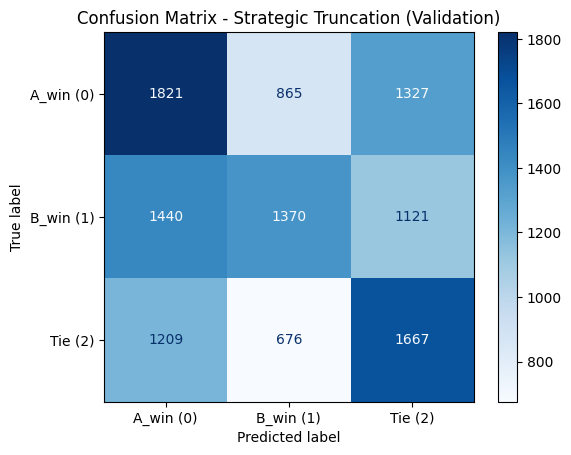


Classification Report (Validation Set):

              precision    recall  f1-score   support

   A_win (0)       0.41      0.45      0.43      4013
   B_win (1)       0.47      0.35      0.40      3931
     Tie (2)       0.41      0.47      0.43      3552

    accuracy                           0.42     11496
   macro avg       0.43      0.42      0.42     11496
weighted avg       0.43      0.42      0.42     11496



In [10]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

# --- 9. [추가] 훈련 결과 분석: 혼동 행렬 (Confusion Matrix) ---
print("\n--- 훈련 결과 분석 (Validation Set) ---")

# 1. (훈련이 끝난 후) val_dataset에 대한 예측 실행
print("Running predictions on validation set...")
predictions_output = trainer.predict(val_dataset)

# 2. 예측 결과에서 로짓(logits)과 실제 레이블 추출
logits = predictions_output.predictions
y_true = predictions_output.label_ids

# 3. 로짓을 argmax를 통해 최종 예측 레이블(0, 1, 2)로 변환
y_pred = np.argmax(logits, axis=1)

# 4. 레이블 이름 정의 (0=A승, 1=B승, 2=무승부)
labels = ["A_win (0)", "B_win (1)", "Tie (2)"]

# 5. Confusion Matrix 시각화
print("Plotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Strategic Truncation (Validation)")
plt.show()

# 6. (보너스) F1-score 등 상세 리포트 출력
print("\nClassification Report (Validation Set):\n")
print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
from sklearn.isotonic import IsotonicRegression
import os
os.environ["WANDB_DISABLED"] = "true"

# Create a dataset for the validation text
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")
class TempDataset(torch.utils.data.Dataset):
    def __init__(self, encodings): self.encodings = encodings
    def __getitem__(self, idx): return {key: val[idx] for key, val in self.encodings.items()}
    def __len__(self): return len(self.encodings['input_ids'])
val_temp_dataset = TempDataset(val_encodings)

# dummy trainer to run predictions easily
dummy_trainer = Trainer(model=lora_model)
val_predictions = dummy_trainer.predict(val_temp_dataset)
val_probs = torch.nn.functional.softmax(torch.from_numpy(val_predictions.predictions), dim=-1).numpy()

# Train calibrators
calibrators = {}
for i in range(3):
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    y_cal = (val_labels.to_numpy() == i).astype(int)
    iso_reg.fit(val_probs[:, i], y_cal)
    calibrators[i] = iso_reg

print("Calibration models trained.")

Calibration models trained.


In [11]:
# 1. 레이블만 생성하는 간단한 전처리 함수
def add_labels_only(example):
    # .map()의 새 프로세스를 위해 numpy 임포트
    import numpy as np

    if example["winner_model_a"] == 1:
        example["labels"] = 0
    elif example["winner_model_b"] == 1:
        example["labels"] = 1
    elif example["winner_tie"] == 1:
        example["labels"] = 2
    else:
        example["labels"] = -1
    return example


print("Re-creating validation set texts (this is fast)...")
# 2. 레이블 추가 (batched=False, num_proc=1)
dataset_with_labels = raw_dataset["train"].map(add_labels_only, num_proc=1)

# 3. -1 레이블 필터링
filtered_dataset = dataset_with_labels.filter(
    lambda example: example["labels"] != -1, num_proc=1
)

# 4. ClassLabel 캐스팅
casted_dataset = filtered_dataset.cast_column("labels", ClassLabel(num_classes=3))

# 5. (중요) 훈련 때와 *똑같은* 시드와 비율로 스플릿
# (seed=42, test_size=0.2, stratify_by_column="labels")
temp_final_datasets = casted_dataset.train_test_split(
    test_size=0.2, stratify_by_column="labels", seed=42
)

# 6. 원본 텍스트가 포함된 validation set 확보
# 이 데이터셋은 y_true, y_pred 배열과 순서가 1:1로 일치합니다.
val_texts_dataset = temp_final_datasets["test"]
print("Validation texts recreated.")

# 7. Pandas로 변환하여 분석
df_report = pd.DataFrame(val_texts_dataset)
df_report["pred_label"] = y_pred
df_report["true_label"] = y_true

# 8. 틀린 것들만 필터링
df_errors = df_report[df_report["true_label"] != df_report["pred_label"]]

print(f"\n--- 😱 총 {len(df_errors)}개의 예측 오류 ---")

# 9. 레이블 이름 맵 (이전과 동일)
label_names = {0: "A_win (0)", 1: "B_win (1)", 2: "Tie (2)"}

# 10. 상위 10개의 오류만 출력
for index, row in df_errors.head(10).iterrows():
    print("=" * 40)
    print(f"오류 ID: {index}")
    print(f"    👉 정답 (True): {label_names[row['true_label']]}")
    print(f"    👉 예측 (Pred): {label_names[row['pred_label']]}")
    print("=" * 40)

    print("\n[Prompt]:")
    print(row["prompt"])

    print("\n[Response A]:")
    print(row["response_a"])

    print("\n[Response B]:")
    print(row["response_b"])
    print("\n" + "-" * 40 + "\n")

print(f"\n...(총 {len(df_errors)}개 오류 중 상위 10개만 출력)...")

Re-creating validation set texts (this is fast)...


Casting the dataset: 100%|██████████| 57477/57477 [00:00<00:00, 114086.04 examples/s]


Validation texts recreated.

--- 😱 총 6638개의 예측 오류 ---
오류 ID: 1
    👉 정답 (True): B_win (1)
    👉 예측 (Pred): A_win (0)

[Prompt]:
["simplify this; The literature on marriage, labor market participation, and family structure reveals intricate connections between demographic trends and economic outcomes. Studies such as Cajner et al. (2017) highlight the disparities in education, marriage rates, and labor market participation across racial and ethnic groups, emphasizing the role of marital status in influencing participation rate gaps. Kleven's (2022) insights into single motherhood and labor market dynamics provide a nuanced understanding of how government policies, such as welfare reform, shape the decisions of single mothers to enter or remain in the workforce. The work of Blau and Kahn (2017) underscores the importance of women's labor force participation in the context of changing gender roles, with married women playing a significant role in the \"quiet revolution\" that contributed 